# Acquisition

#### imports

In [1178]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from env import get_connection
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from prepare import encode_categorical_columns, train_val_test, theometrics

Acquiring the telco_churn dataset

In [1179]:
db_url = get_connection('telco_churn')

query = '''
       SELECT 
    customers.customer_id,
    customers.gender,
    customers.senior_citizen,
    customers.partner,
    customers.dependents,
    customers.tenure,
    customers.phone_service,
    customers.multiple_lines,
    customers.online_security,
    customers.online_backup,
    customers.device_protection,
    customers.tech_support,
    customers.streaming_tv,
    customers.streaming_movies,
    customers.paperless_billing,
    customers.monthly_charges,
    customers.total_charges,
    customers.churn,
    payment_types.payment_type,
    contract_types.contract_type,
    internet_service_types.internet_service_type
FROM
    customers
        LEFT JOIN
    customer_details ON customer_details.customer_id = customers.customer_id
        LEFT JOIN
    customer_contracts ON customer_contracts.customer_id = customer_details.customer_id
        LEFT JOIN
    customer_payments ON customer_payments.customer_id = customer_contracts.customer_id
        LEFT JOIN
    customer_signups ON customer_signups.customer_id = customer_payments.customer_id
        LEFT JOIN
    customer_subscriptions ON customer_subscriptions.customer_id = customer_signups.customer_id
        LEFT JOIN
    customer_churn ON customer_churn.customer_id = customer_subscriptions.customer_id
        LEFT JOIN
    payment_types ON payment_types.payment_type_id = customers.payment_type_id
        LEFT JOIN
    contract_types ON contract_types.contract_type_id = customer_contracts.contract_type_id
        LEFT JOIN
    internet_service_types ON internet_service_types.internet_service_type_id = customers.internet_service_type_id;
        '''

In [1180]:
#reading the sql query into a dataframe

telco_df = pd.read_sql(query, db_url)
telco_df.head().T

,0,1,2,3,4
customer_id,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ
gender,Female,Male,Male,Male,Female
senior_citizen,0,0,0,1,1
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,No,No
tenure,9,9,4,13,3
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,No,Yes,No,No,No
online_security,No,No,No,No,No
online_backup,Yes,No,No,Yes,No


# preparation

cleaning up telco dataset

In [1181]:
#dropping the customer_id column

telco_df = telco_df.drop(columns = ['customer_id'])
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,No,Mailed check,One year,DSL
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.4,No,Mailed check,Month-to-month,DSL
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Yes,Electronic check,Month-to-month,Fiber optic
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Yes,Electronic check,Month-to-month,Fiber optic
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.4,Yes,Mailed check,Month-to-month,Fiber optic


In [1182]:
#checking how many columns and rows ar in the dataframe

telco_df.shape

(7043, 20)

In [1183]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   object 
 3   dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   object 
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   online_backup          7043 non-null   object 
 9   device_protection      7043 non-null   object 
 10  tech_support           7043 non-null   object 
 11  streaming_tv           7043 non-null   object 
 12  streaming_movies       7043 non-null   object 
 13  paperless_billing      7043 non-null   object 
 14  monthly_charges        7043 non-null   float64
 15  tota

In [1184]:
#checking all rows with no values

(telco_df == ' ').sum()

gender                    0
senior_citizen            0
partner                   0
dependents                0
tenure                    0
phone_service             0
multiple_lines            0
online_security           0
online_backup             0
device_protection         0
tech_support              0
streaming_tv              0
streaming_movies          0
paperless_billing         0
monthly_charges           0
total_charges            11
churn                     0
payment_type              0
contract_type             0
internet_service_type     0
dtype: int64

In [1185]:
#checking all rows in total_charges with no values

telco_df[(telco_df.total_charges == ' ')]

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
945,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,Yes,Yes,Yes,No,No,56.05,,No,Credit card (automatic),Two year,DSL
1731,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.00,,No,Mailed check,Two year,None
1906,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,,No,Bank transfer (automatic),Two year,DSL
2025,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,19.70,,No,Mailed check,One year,None
2176,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.25,,No,Mailed check,Two year,None
2250,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.35,,No,Mailed check,Two year,None
2855,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,,No,Mailed check,Two year,DSL
3052,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.75,,No,Mailed check,Two year,None
3118,Female,0,Yes,Yes,0,No,No phone service,Yes,No,Yes,Yes,Yes,No,Yes,52.55,,No,Bank transfer (automatic),Two year,DSL
4054,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,,No,Mailed check,Two year,DSL


In [1186]:
#replacing all the total charges rows with no values with 0

telco_df['total_charges'] = telco_df['total_charges'].replace(' ', 0)

In [1187]:
#verifying all the rows with 0 

telco_df[(telco_df.total_charges == 0)]

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
945,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,Yes,Yes,Yes,No,No,56.05,0,No,Credit card (automatic),Two year,DSL
1731,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.00,0,No,Mailed check,Two year,None
1906,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,0,No,Bank transfer (automatic),Two year,DSL
2025,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,19.70,0,No,Mailed check,One year,None
2176,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.25,0,No,Mailed check,Two year,None
2250,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.35,0,No,Mailed check,Two year,None
2855,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,0,No,Mailed check,Two year,DSL
3052,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.75,0,No,Mailed check,Two year,None
3118,Female,0,Yes,Yes,0,No,No phone service,Yes,No,Yes,Yes,Yes,No,Yes,52.55,0,No,Bank transfer (automatic),Two year,DSL
4054,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,0,No,Mailed check,Two year,DSL


In [1188]:
#changing 

In [1189]:
telco_df.contract_type.value_counts()

contract_type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [1190]:
#checking all object types in the dataset

telco_df.dtypes == 'int'

gender                   False
senior_citizen            True
partner                  False
dependents               False
tenure                    True
phone_service            False
multiple_lines           False
online_security          False
online_backup            False
device_protection        False
tech_support             False
streaming_tv             False
streaming_movies         False
paperless_billing        False
monthly_charges          False
total_charges            False
churn                    False
payment_type             False
contract_type            False
internet_service_type    False
dtype: bool

In [1191]:
#checking all the null values in the dataset

telco_df.isna().sum()

gender                   0
senior_citizen           0
partner                  0
dependents               0
tenure                   0
phone_service            0
multiple_lines           0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
paperless_billing        0
monthly_charges          0
total_charges            0
churn                    0
payment_type             0
contract_type            0
internet_service_type    0
dtype: int64

In [1192]:
#encoding the categorical columns

categorical_columns = ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security',
                       'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                       'contract_type', 'internet_service_type', 'payment_type', 'churn', 'paperless_billing']

In [1193]:
telco_df = encode_categorical_columns(telco_df, categorical_columns)
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
0,0,0,1,1,9,1,0,0,2,0,2,2,0,Yes,65.6,593.3,0,3,1,0
1,1,0,0,0,9,1,2,0,0,0,0,0,2,No,59.9,542.4,0,3,0,0
2,1,0,0,0,4,1,0,0,0,2,0,0,0,Yes,73.9,280.85,1,2,0,1
3,1,1,1,0,13,1,0,0,2,2,0,2,2,Yes,98.0,1237.85,1,2,0,1
4,0,1,1,0,3,1,0,0,0,0,2,2,0,Yes,83.9,267.4,1,3,0,1


In [1194]:
#encoding multi-categorical columns

telco_df = pd.get_dummies(telco_df, columns =  ['multiple_lines', 'online_security', 'online_backup',
                                     'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
                                     'payment_type', 'contract_type', 'internet_service_type'])
telco_df = pd.get_dummies(telco_df, columns = ['paperless_billing'], drop_first = True)
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,monthly_charges,total_charges,churn,multiple_lines_0,...,payment_type_1,payment_type_2,payment_type_3,contract_type_0,contract_type_1,contract_type_2,internet_service_type_0,internet_service_type_1,internet_service_type_2,paperless_billing_Yes
0,0,0,1,1,9,1,65.6,593.3,0,True,...,False,False,True,False,True,False,True,False,False,True
1,1,0,0,0,9,1,59.9,542.4,0,False,...,False,False,True,True,False,False,True,False,False,False
2,1,0,0,0,4,1,73.9,280.85,1,True,...,False,True,False,True,False,False,False,True,False,True
3,1,1,1,0,13,1,98.0,1237.85,1,True,...,False,True,False,True,False,False,False,True,False,True
4,0,1,1,0,3,1,83.9,267.4,1,True,...,False,False,True,True,False,False,False,True,False,True


In [1195]:
telco_df.shape

(7043, 41)

In [1196]:
#telco_df = telco_df.drop(columns = ['online_backup_1', 'tech_support_1', 'online_security_1', 
#                        'device_protection_1', 'multiple_lines_1', 'phone_service', 
#                         'streaming_tv_1', 'internet_service_type_2', 'streaming_movies_1'
#                                  ]) 

In [1197]:
telco_df.shape

(7043, 41)

In [1198]:
telco_df.head().T

,0,1,2,3,4
gender,0,1,1,1,0
senior_citizen,0,0,0,1,1
partner,1,0,0,1,1
dependents,1,0,0,0,0
tenure,9,9,4,13,3
phone_service,1,1,1,1,1
monthly_charges,65.6,59.9,73.9,98.0,83.9
total_charges,593.3,542.4,280.85,1237.85,267.4
churn,0,0,1,1,1
multiple_lines_0,True,False,True,True,True


# Exploration and preprocessing

### splitting the dataset into train, validate and test subsets

In [1199]:
train, val, test = train_val_test(telco_df, strat = 'churn')
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,monthly_charges,total_charges,churn,multiple_lines_0,...,payment_type_1,payment_type_2,payment_type_3,contract_type_0,contract_type_1,contract_type_2,internet_service_type_0,internet_service_type_1,internet_service_type_2,paperless_billing_Yes
5609,1,0,0,0,14,1,76.45,1117.55,0,True,...,False,True,False,True,False,False,False,True,False,False
2209,1,0,0,0,5,1,70.00,347.4,1,True,...,False,False,True,False,True,False,True,False,False,True
6919,1,0,1,0,35,1,75.20,2576.2,1,False,...,False,True,False,True,False,False,False,True,False,True
2284,1,0,1,0,58,1,86.10,4890.5,0,False,...,False,True,False,False,False,True,True,False,False,True
845,0,0,0,0,2,1,49.60,114.7,1,True,...,False,False,True,True,False,False,True,False,False,True


In [1200]:
#checking the number of columns and rows in each subset

train.shape, val.shape, test.shape

((4930, 41), (1056, 41), (1057, 41))

In [1201]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [1202]:
# creating a baseline of the most occuring number in the survived column

(y_train == 0).mean()

0.734685598377282

Baseline accuracy is 73%

In [1203]:
#verifying that x and y train have the same amount of rows

X_train.shape[:1], y_train.shape[:1]

((4930,), (4930,))

In [1204]:
#verifying that x and y val have the same amount of rows

X_val.shape[:1], y_val.shape[:1]

((1056,), (1056,))

In [1205]:
#verifying that x and y test have the same amount of rows

X_test.shape[:1], y_test.shape[:1]

((1057,), (1057,))

In [1206]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,monthly_charges,total_charges,churn,multiple_lines_0,...,payment_type_1,payment_type_2,payment_type_3,contract_type_0,contract_type_1,contract_type_2,internet_service_type_0,internet_service_type_1,internet_service_type_2,paperless_billing_Yes
5609,1,0,0,0,14,1,76.45,1117.55,0,True,...,False,True,False,True,False,False,False,True,False,False
2209,1,0,0,0,5,1,70.00,347.4,1,True,...,False,False,True,False,True,False,True,False,False,True
6919,1,0,1,0,35,1,75.20,2576.2,1,False,...,False,True,False,True,False,False,False,True,False,True
2284,1,0,1,0,58,1,86.10,4890.5,0,False,...,False,True,False,False,False,True,True,False,False,True
845,0,0,0,0,2,1,49.60,114.7,1,True,...,False,False,True,True,False,False,True,False,False,True


In [1207]:
#transforming age and fare in both the X_train and X_val subsets using MinMaxScaler()

mms = MinMaxScaler()

X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])
X_test[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_test[['tenure', 'monthly_charges', 'total_charges']])

X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,monthly_charges,total_charges,multiple_lines_0,multiple_lines_1,...,payment_type_1,payment_type_2,payment_type_3,contract_type_0,contract_type_1,contract_type_2,internet_service_type_0,internet_service_type_1,internet_service_type_2,paperless_billing_Yes
5609,1,0,0,0,0.194444,1,0.578475,0.128679,True,False,...,False,True,False,True,False,False,False,True,False,False
2209,1,0,0,0,0.069444,1,0.514200,0.040001,True,False,...,False,False,True,False,True,False,True,False,False,True
6919,1,0,1,0,0.486111,1,0.566019,0.296633,False,False,...,False,True,False,True,False,False,False,True,False,True
2284,1,0,1,0,0.805556,1,0.674639,0.563110,False,False,...,False,True,False,False,False,True,True,False,False,True
845,0,0,0,0,0.027778,1,0.310912,0.013207,True,False,...,False,False,True,True,False,False,True,False,False,True


## statistical tests

#### performing a chi2 test to determine if having tech support affects churn

Null hypothesis: Having tech support DOES NOT affect churn.

Alternative hypothesis: Having tech support AFFECTS churn.

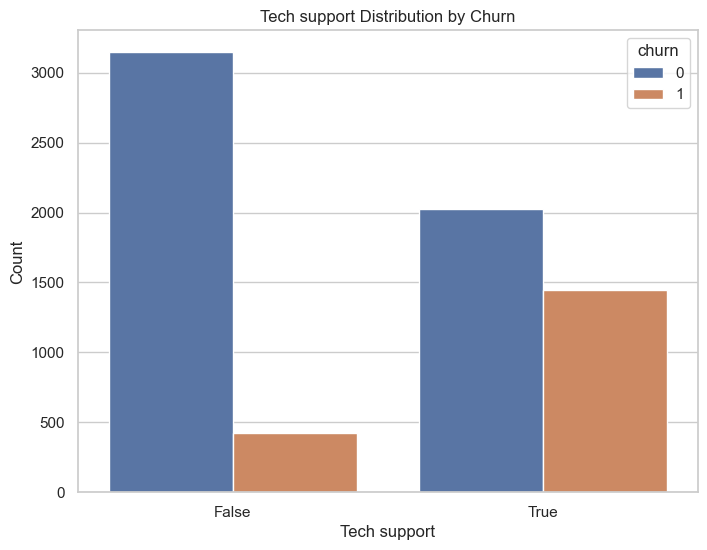

In [1208]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=telco_df, x='tech_support_0', hue='churn')
plt.title("Tech support Distribution by Churn")
plt.xlabel("Tech support")
plt.ylabel("Count")
plt.show()

From the above plot we can discern that tech support DOES affect churn with almost half of tech support having customers churning

In [1209]:
ct = pd.crosstab(telco_df.churn, telco_df.tech_support_0)
ct

tech_support_0,False,True
churn,,
0,3147,2027
1,423,1446


In [1210]:
chi, p, degf, exp = stats.chi2_contingency(ct)

In [1211]:
p

6.35740755126359e-176

In [1212]:
a = 0.05

if p < a:
    print('we reject the null hypothesis. There appears to be a relationship')
else:
    print('we fail to reject the null hypothesis')

we reject the null hypothesis. There appears to be a relationship


The chi^2 test produced a p value of (6.35740755126359e-176) which is significantly lower than our cutoff of 0.05 indicating that there is a strong correlation between having tech support and churn.

#### performing a t-test to determine if tenure has a direct relationship with churn

Null hypothesis: Tenure DOES NOT have a direct relationship with churn.

Alternative hypothesis: Tenure has a direct relationship with churn.

/var/folders/7d/j3xl67tj7_182fyw9tbm3rkm0000gn/T/ipykernel_4009/4012086723.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=telco_df, x='churn', y='tenure', ci='sd', capsize=0.1)


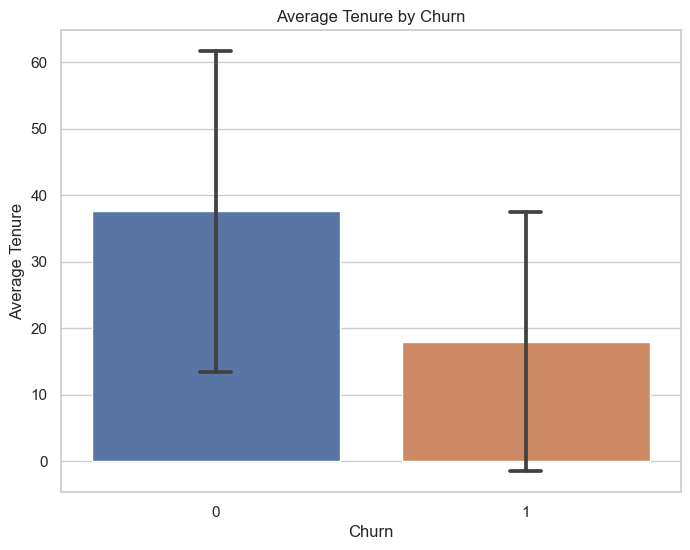

In [1213]:
plt.figure(figsize=(8, 6))
sns.barplot(data=telco_df, x='churn', y='tenure', ci='sd', capsize=0.1)
plt.title("Average Tenure by Churn")
plt.xlabel("Churn")
plt.ylabel("Average Tenure")
plt.show()

The above bar plot shows the average tenure for both churn groups and shows that the longer the customer is with the company the less likely it is for them to churn.

In [1214]:
# Splitting the data into two groups: churn = Yes and churn = No
tenure_churn_yes = telco_df[telco_df['churn'] == 1]['tenure']
tenure_churn_no = telco_df[telco_df['churn'] == 0]['tenure']

In [1215]:
# Performing an independent t-test
t, p = stats.ttest_ind(tenure_churn_yes, tenure_churn_no, equal_var=False)

In [1216]:
p

1.1954945472607144e-232

In [1217]:
a = 0.05

if p < a:
    print("Reject the null hypothesis: Tenure has a significant effect on churn.")
else:
    print("Fail to reject the null hypothesis: Tenure does not have a significant effect on churn.")

Reject the null hypothesis: Tenure has a significant effect on churn.


The independent t-test produced a p value of (1.1954945472607144e-232) which is significantly lower than our cutoff of 0.05 indicating that there is a direct relationship between tenure and the churn.

# modeling

## model 1

In [1218]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [1219]:
#creating a model and fitting it to our train set

seed = 42

rf = RandomForestClassifier(max_depth = 8, min_samples_leaf = 7, random_state = seed)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=7, random_state=42)

In [1220]:
#train model score

rf.score(X_train, y_train)

0.8288032454361055

In [1221]:
#validate model score

rf.score(X_val, y_val)

0.8039772727272727

In [1222]:
t_pred = rf.predict(X_train)
t_pred[:5]

array([0, 0, 1, 0, 0])

In [1223]:
v_pred = rf.predict(X_val)
v_pred[:5]

array([0, 0, 0, 0, 1])

In [1224]:
#checking the importance of each feature in the dataset before making predictions

rf.feature_importances_

array([0.00676272, 0.00738703, 0.00803871, 0.00609034, 0.15334101,
       0.00342058, 0.06142547, 0.10190831, 0.0055123 , 0.00334123,
       0.00615852, 0.05512734, 0.00589523, 0.01164693, 0.02367199,
       0.00855349, 0.00790179, 0.00983059, 0.00511583, 0.00623707,
       0.06173189, 0.0054641 , 0.01364792, 0.00577865, 0.00665647,
       0.00671784, 0.00539436, 0.0025886 , 0.00525137, 0.00518189,
       0.00417022, 0.04031328, 0.00499584, 0.17485928, 0.01957092,
       0.04015101, 0.02277812, 0.0587486 , 0.00493363, 0.01369952])

In [1225]:
#making sure all my features add up to 1

np.array([0.00770559, 0.00831973, 0.00795943, 0.00755928, 0.15948442,
       0.07830179, 0.10454558, 0.00644501, 0.0078437 , 0.06704834,
       0.01240007, 0.02350327, 0.0082417 , 0.01982384, 0.00418228,
       0.07070717, 0.01245629, 0.00674605, 0.00690064, 0.00537752,
       0.00669755, 0.00519544, 0.00493247, 0.05239282, 0.00425189,
       0.13529772, 0.02686298, 0.04213504, 0.01943576, 0.05850772,
       0.01873888]).sum()

0.9999999700000001

In [1226]:
#visualizing the important features in the dataset from most to least important

fi = pd.DataFrame({'feature' : X_train.columns,
              'importance' : rf.feature_importances_})

fi.sort_values(by = 'importance', ascending = False)

,feature,importance
33,contract_type_0,0.174859
4,tenure,0.153341
7,total_charges,0.101908
20,tech_support_0,0.061732
6,monthly_charges,0.061425
37,internet_service_type_1,0.058749
11,online_security_0,0.055127
31,payment_type_2,0.040313
35,contract_type_2,0.040151
14,online_backup_0,0.023672


In [1227]:
seed = 42
train_acc = []
val_acc = []
depth = []
min_samples_leaf = []

for i in (reversed(range(5, 10))):

    for n in range(5, 10):

        rf = RandomForestClassifier(max_depth = i, min_samples_leaf = n, random_state = seed)
    
        rf.fit(X_train, y_train)
    
        train_acc.append(rf.score(X_train, y_train))
    
        val_acc.append(rf.score(X_val, y_val))
    
        depth.append(i)

        min_samples_leaf.append(n)

In [1228]:
trees = pd.DataFrame({'max_depth' : depth, 'min_sam_leaf' : min_samples_leaf, 'train_acc' : train_acc, 'val_acc' : val_acc})
trees.sort_values(by = 'val_acc', ascending = False).head(10)

,max_depth,min_sam_leaf,train_acc,val_acc
1,9,6,0.835700,0.811553
5,8,5,0.830223,0.809659
3,9,8,0.833469,0.806818
17,6,7,0.816024,0.806818
4,9,9,0.832049,0.805871
16,6,6,0.816633,0.805871
9,8,9,0.825963,0.804924
2,9,7,0.833671,0.804924
0,9,5,0.838134,0.803977
12,7,7,0.823732,0.803977


In [1229]:
seed = 42
train_acc = []
val_acc = []
depth = []

for i in range(2, 10):

        rf = RandomForestClassifier(max_depth = i, min_samples_leaf = 7, random_state = seed)
    
        rf.fit(X_train, y_train)
    
        train_acc.append(rf.score(X_train, y_train))
    
        val_acc.append(rf.score(X_val, y_val))
    
        depth.append(i)

        min_samples_leaf.append(7)

In [1230]:
trees = pd.DataFrame({'max_depth' : depth, 'train_acc' : train_acc, 'val_acc' : val_acc})
trees.sort_values(by = 'val_acc', ascending = False)

,max_depth,train_acc,val_acc
4,6,0.816024,0.806818
7,9,0.833671,0.804924
5,7,0.823732,0.803977
6,8,0.828803,0.803977
1,3,0.790669,0.791667
3,5,0.807099,0.788826
2,4,0.799189,0.787879
0,2,0.773631,0.771780


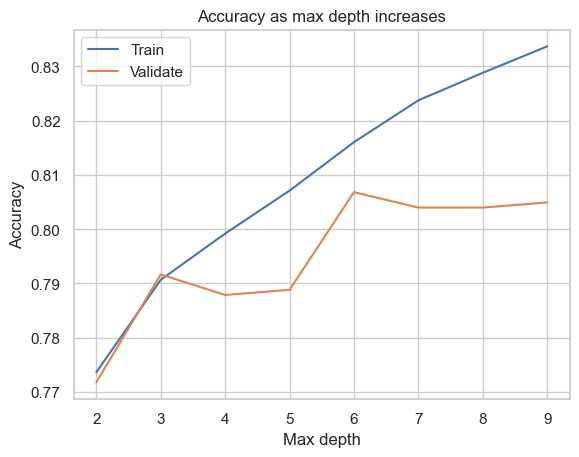

In [1231]:
plt.plot(trees.max_depth, trees.train_acc, label = 'Train')
plt.plot(trees.max_depth, trees.val_acc, label = 'Validate')
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
plt.title('Accuracy as max depth increases')
plt.legend()
plt.show()

### Model score

In [1232]:
rf.score(X_train, y_train)

0.8336713995943205

### Confusion matrix

In [1233]:
confusion_matrix(y_train, t_pred)

array([[3357,  265],
       [ 579,  729]])

### Classification report

In [1234]:
print(classification_report(y_train, t_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3622
           1       0.73      0.56      0.63      1308

    accuracy                           0.83      4930
   macro avg       0.79      0.74      0.76      4930
weighted avg       0.82      0.83      0.82      4930



### Train metrics

In [1235]:
theometrics(3357, 729, 579, 265)

,metric,value
0,Accuracy,0.828803
1,Recall,0.926836
2,True Positive Rate,0.926836
3,False Positive Rate,0.442661
4,True Negative Rate,0.557339
5,False Negative Rate,0.073164
6,Precision,0.852896
7,F1-Score,0.888330
8,Support,3622.000000


### Validate metrics

In [1236]:
confusion_matrix(y_val, v_pred)

array([[702,  74],
       [133, 147]])

In [1237]:
theometrics(702, 147, 133, 74)

,metric,value
0,Accuracy,0.803977
1,Recall,0.904639
2,True Positive Rate,0.904639
3,False Positive Rate,0.475000
4,True Negative Rate,0.525000
5,False Negative Rate,0.095361
6,Precision,0.840719
7,F1-Score,0.871508
8,Support,776.000000


## model 2

In [1238]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [1239]:
#defining my train and val subsets

X_train = train[['tenure', 'monthly_charges', 'total_charges']]
y_train = train.churn

X_val = val[['tenure', 'monthly_charges', 'total_charges']]
y_val = val.churn

In [1240]:
#transforming age and fare in both the X_train and X_val subsets using MinMaxScaler()

mms = MinMaxScaler()

X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])
X_test[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_test[['tenure', 'monthly_charges', 'total_charges']])

X_train.head()

/var/folders/7d/j3xl67tj7_182fyw9tbm3rkm0000gn/T/ipykernel_4009/2716390687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
/var/folders/7d/j3xl67tj7_182fyw9tbm3rkm0000gn/T/ipykernel_4009/2716390687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])


,tenure,monthly_charges,total_charges
5609,0.194444,0.578475,0.128679
2209,0.069444,0.514200,0.040001
6919,0.486111,0.566019,0.296633
2284,0.805556,0.674639,0.563110
845,0.027778,0.310912,0.013207


In [1241]:
#defining the baseline

(y_train == 0).mean()

0.734685598377282

In [1242]:

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

In [1243]:
y_pred = knn.predict(X_train)
v_pred = knn.predict(X_val)

In [1244]:
#train model score

knn.score(X_train, y_train)

0.7975659229208925

In [1245]:
#validate model score

knn.score(X_val, y_val)

0.8087121212121212

In [1246]:
seed = 42
t_acc = []
v_acc = []
n_neighbors = []

for i in range(20, 35):

    knn = KNeighborsClassifier(n_neighbors = i)

    knn.fit(X_train, y_train)

    t_acc.append(knn.score(X_train, y_train))

    v_acc.append(knn.score(X_val, y_val))

    n_neighbors.append(i)

In [1247]:
df = pd.DataFrame({'n_neighbors' : n_neighbors, 'train_acc' : t_acc, 'val_acc' : v_acc})
df.sort_values(by = 'val_acc', ascending = False)

,n_neighbors,train_acc,val_acc
10,30,0.797566,0.808712
13,33,0.796755,0.805871
9,29,0.800000,0.803977
12,32,0.796957,0.803977
11,31,0.799391,0.803030
14,34,0.796349,0.803030
7,27,0.800203,0.802083
6,26,0.796755,0.801136
8,28,0.797566,0.798295
5,25,0.800811,0.795455


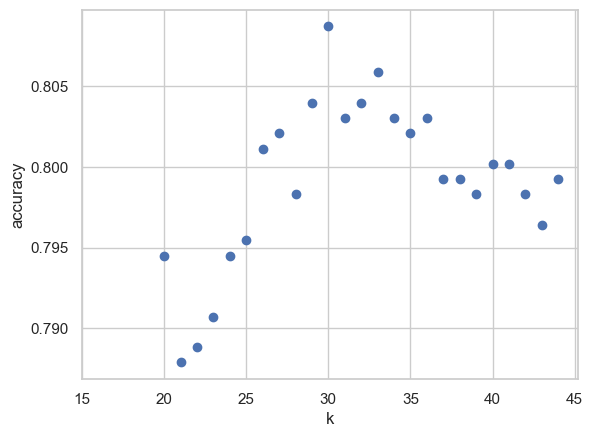

In [1248]:
k_range = range(20, 45)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_val, y_val))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([15,20,25,30,35,40,45])
plt.show()

### confusion matrix

In [1249]:
confusion_matrix(y_train, y_pred)

array([[3362,  260],
       [ 738,  570]])

### classification report

In [1250]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3622
           1       0.69      0.44      0.53      1308

    accuracy                           0.80      4930
   macro avg       0.75      0.68      0.70      4930
weighted avg       0.78      0.80      0.78      4930



### train metrics

In [1251]:
theometrics(3362, 570, 738, 260)

,metric,value
0,Accuracy,0.797566
1,Recall,0.928216
2,True Positive Rate,0.928216
3,False Positive Rate,0.564220
4,True Negative Rate,0.435780
5,False Negative Rate,0.071784
6,Precision,0.820000
7,F1-Score,0.870759
8,Support,3622.000000


### validate metrics

In [1252]:
confusion_matrix(y_val, v_pred)

array([[715,  61],
       [141, 139]])

In [1253]:
theometrics(715, 139, 141, 61)

,metric,value
0,Accuracy,0.808712
1,Recall,0.921392
2,True Positive Rate,0.921392
3,False Positive Rate,0.503571
4,True Negative Rate,0.496429
5,False Negative Rate,0.078608
6,Precision,0.835280
7,F1-Score,0.876225
8,Support,776.000000


## model 3

In [1254]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [1255]:
#transforming age and fare in both the X_train and X_val subsets using MinMaxScaler()

mms = MinMaxScaler()

X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])
X_test[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_test[['tenure', 'monthly_charges', 'total_charges']])

X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,monthly_charges,total_charges,multiple_lines_0,multiple_lines_1,...,payment_type_1,payment_type_2,payment_type_3,contract_type_0,contract_type_1,contract_type_2,internet_service_type_0,internet_service_type_1,internet_service_type_2,paperless_billing_Yes
5609,1,0,0,0,0.194444,1,0.578475,0.128679,True,False,...,False,True,False,True,False,False,False,True,False,False
2209,1,0,0,0,0.069444,1,0.514200,0.040001,True,False,...,False,False,True,False,True,False,True,False,False,True
6919,1,0,1,0,0.486111,1,0.566019,0.296633,False,False,...,False,True,False,True,False,False,False,True,False,True
2284,1,0,1,0,0.805556,1,0.674639,0.563110,False,False,...,False,True,False,False,False,True,True,False,False,True
845,0,0,0,0,0.027778,1,0.310912,0.013207,True,False,...,False,False,True,True,False,False,True,False,False,True


In [1256]:
#defining the baseline

(y_train == 0).mean()

0.734685598377282

In [1257]:
#building the LogisticRegression model

seed = 42

logreg = LogisticRegression(random_state = seed, max_iter = 300, solver = 'liblinear', penalty = 'l1')

In [1258]:
#fitting the model on the train set

logreg.fit(X_train, y_train)

LogisticRegression(max_iter=300, penalty='l1', random_state=42,
                   solver='liblinear')

In [1259]:
#train model score

logreg.score(X_train, y_train)

0.8097363083164301

In [1260]:
#validate model score

logreg.score(X_val, y_val)

0.8001893939393939

In [1261]:
#generating the x_train and x_val predictions and assigning it to y_pred and v_pred

y_pred = logreg.predict(X_train)
v_pred = logreg.predict(X_val)

### confusion matrix

In [1262]:
confusion_matrix(y_train, y_pred)

array([[3255,  367],
       [ 571,  737]])

### classification report

In [1263]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3622
           1       0.67      0.56      0.61      1308

    accuracy                           0.81      4930
   macro avg       0.76      0.73      0.74      4930
weighted avg       0.80      0.81      0.80      4930



### train metrics

In [1267]:
theometrics(3255, 737, 572, 367)

,metric,value
0,Accuracy,0.809572
1,Recall,0.898675
2,True Positive Rate,0.898675
3,False Positive Rate,0.436975
4,True Negative Rate,0.563025
5,False Negative Rate,0.101325
6,Precision,0.850536
7,F1-Score,0.873943
8,Support,3622.000000


### validate metrics

In [1265]:
confusion_matrix(y_val, v_pred)

array([[692,  84],
       [127, 153]])

In [1268]:
theometrics(692, 153, 127, 84)

,metric,value
0,Accuracy,0.800189
1,Recall,0.891753
2,True Positive Rate,0.891753
3,False Positive Rate,0.453571
4,True Negative Rate,0.546429
5,False Negative Rate,0.108247
6,Precision,0.844933
7,F1-Score,0.867712
8,Support,776.000000
